# Inference plots - Pairwise scatterplots

This example extends from the inference-adaptive-covariance-mcmc: https://github.com/pints-team/pints/blob/master/examples/inference-adaptive-covariance-mcmc.ipynb, and shows you different way to plot the results of an MCMC routine.

Inference plots
* [Trace plots](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-trace-plots.ipynb)
* __Pairwise scatterplots__
* [Autocorrelation plot](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-autocorrelation.ipynb)
* [Predicted time series](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-predicted-time-series.ipynb)


## Basic MCMC setup

The same setup used in the inference-adaptive-covariance-mcmc example.

In [1]:
from __future__ import print_function
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as pl

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 100)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 50
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleSeriesProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
prior = pints.UniformPrior(
    [0.01, 400, noise*0.1],
    [0.02, 600, noise*100]
    )

# Create a Bayesian log-likelihood (prior * likelihood)
log_likelihood = pints.BayesianLogLikelihood(prior, log_likelihood)

# Run an adaptive mcmc routine
x0 = real_parameters * 1.2
mcmc = pints.AdaptiveCovarianceMCMC(log_likelihood, x0)
mcmc.set_verbose(False)


## Run MCMC

In [2]:
print('Running')
chain = mcmc.run()
print('Done!')


Running
Done!


## Plotting one variable

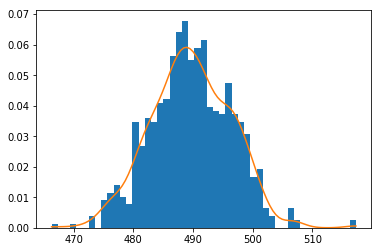

In [3]:
# try plotting 1d
from scipy import stats
def plot_kde_1d(X, ax=None):
    if ax is None:
        ax = pl.gca()
    fig = pl.figure()
    Xmin = np.min(X)
    Xmax = np.max(X)
    x1 = np.linspace(Xmin, Xmax, 100)
    x2 = np.linspace(Xmin, Xmax, 50)
    kernel = stats.gaussian_kde(X)
    Z = kernel(x1)
    hist = ax.hist(X, bins=x2, density=True)
    ax.plot(x1, Z)
    return hist

X = chain[:,1]
fig,ax = pl.subplots(1,1)
plot_kde_1d(X, ax)
pl.show()


## Plotting two variables

### Compare KDE and histogram

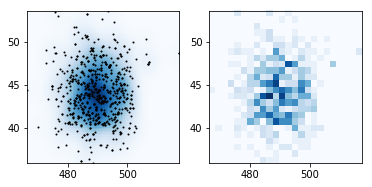

In [4]:
# try plotting 2d
from scipy import stats

def forceAspect(ax,aspect=1):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

def plot_kde_2d(X, Y, ax=None):
    if ax is None:
        ax = pl.gca()
    Xmin, Xmax = np.min(X), np.max(X)
    Ymin, Ymax = np.min(Y), np.max(Y)
    X1, Y1 = np.mgrid[Xmin:Xmax:100j, Ymin:Ymax:100j]
    positions = np.vstack([X1.ravel(), Y1.ravel()])
    values = np.vstack([X, Y])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X1.shape)
    #pl.hist(X, bins=x2, density=True)
    kdeplot = ax.imshow(np.rot90(Z), cmap=pl.cm.Blues, extent=[Xmin, Xmax, Ymin, Ymax])
    forceAspect(ax)
    kdeplot, = ax.plot(X, Y, 'k.', markersize=2)
    return kdeplot

def plot_hist2d(X, Y, ax=None):
    if ax is None:
        ax = pl.gca()
    Xmin, Xmax = np.min(X), np.max(X)
    Ymin, Ymax = np.min(Y), np.max(Y)
    x2 = np.linspace(Xmin, Xmax, 25)
    y2 = np.linspace(Ymin, Ymax, 25)
    histplot = ax.hist2d(X, Y, bins=[x2,y2], normed=True, cmap=pl.cm.Blues)
    forceAspect(ax)
    return histplot

X = chain[:,1]
Y = chain[:,2]
fig, axes = pl.subplots(1, 2)
plot_kde_2d(X, Y, axes[0])
plot_hist2d(X, Y, axes[1])
pl.show()


## Matrix scatter plots

### Histogram version

Plotting the 0th parameter.
Plotting the 1th parameter.
Plotting the 2th parameter.


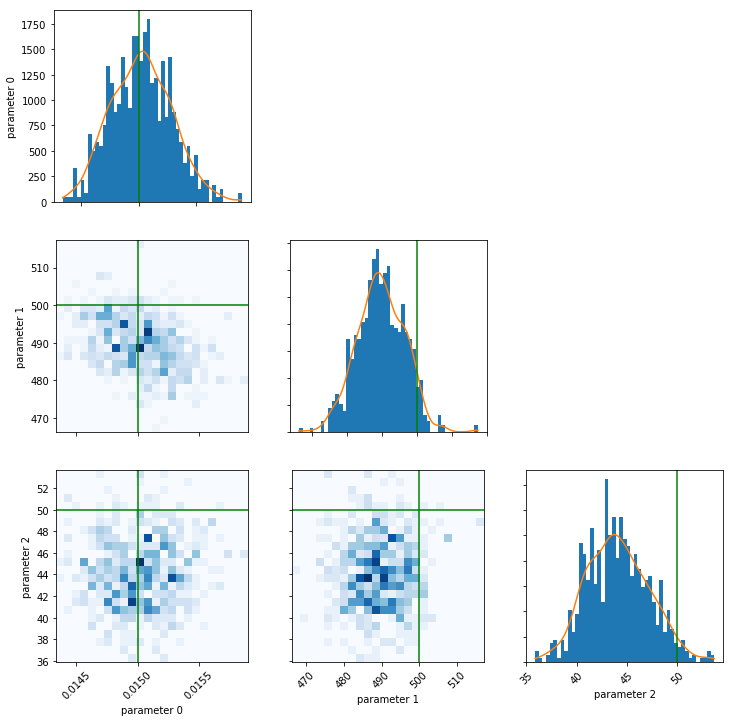

In [5]:
# Plot it! This is long...

n_param = log_likelihood.dimension()
fig_size = (12,12)
verbose = True

fig, axes = pl.subplots(n_param, n_param, figsize=fig_size)
for i in range(n_param):
    if verbose:
        print('Plotting the ' + str(i) + 'th parameter.') 
    for j in range(n_param):
        if i == j:
            # Plot the diagonal
            plot_kde_1d(chain[:, i], ax=axes[i, j])
            # In case we don't have real_parameters
            if len(real_parameters) > i:
                axes[i, j].axvline(real_parameters[i],c='g')
            #TODO plot true values and 95 CI
        elif i < j:
            axes[i, j].axis('off')
        else:
            # Plot the samples as density map
            plot_hist2d(chain[:, j], chain[:, i], ax=axes[i, j])
            # In case we don't have real_parameters
            if len(real_parameters) > j and len(real_parameters) > i:
                axes[i, j].axhline(real_parameters[i],c='g')
                axes[i, j].axvline(real_parameters[j],c='g')
        if i < n_param-1:
            # Only show xticklabels for the last one
            axes[i, j].set_xticklabels([])
        else:
            # Rotation the xticklabels to fit in the plot
            for tl in axes[i, j].get_xticklabels():
                tl.set_rotation(45)
        if j > 0:
            # Only show yticklabels for the first one
            axes[i, j].set_yticklabels([])
    axes[i, 0].set_ylabel('parameter %d'%i)
    axes[-1, i].set_xlabel('parameter %d'%i)

pl.show()


### KDE version

Plotting the 0th parameter.
Plotting the 1th parameter.
Plotting the 2th parameter.


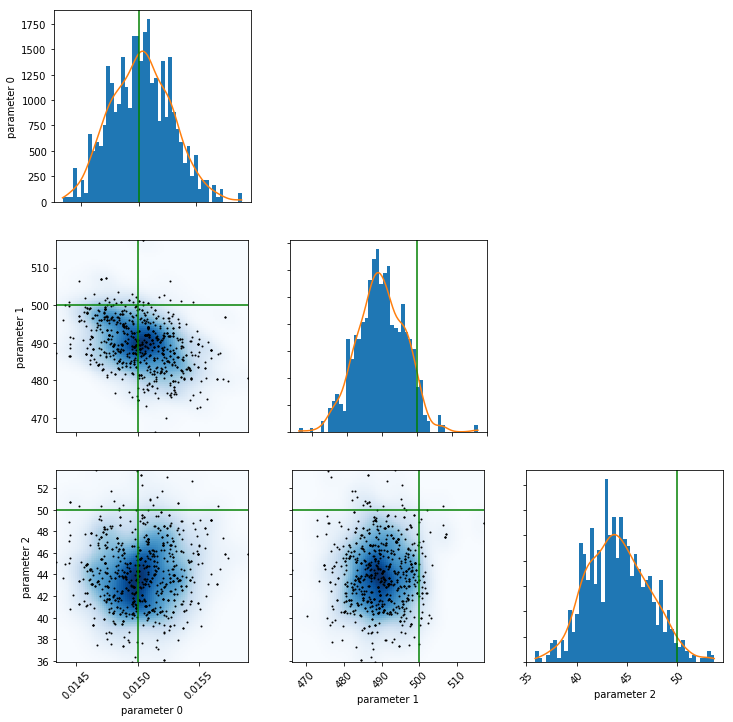

In [6]:
# Plot it! This is long...

n_param = log_likelihood.dimension()
fig_size = (12,12)
verbose = True

fig, axes = pl.subplots(n_param, n_param, figsize=fig_size)
for i in range(n_param):
    if verbose:
        print('Plotting the ' + str(i) + 'th parameter.') 
    for j in range(n_param):
        if i == j:
            # Plot the diagonal
            plot_kde_1d(chain[:, i], ax=axes[i, j])
            # In case we don't have real_parameters
            if len(real_parameters) > i:
                axes[i, j].axvline(real_parameters[i],c='g')
            #TODO plot true values and 95 CI
        elif i < j:
            axes[i, j].axis('off')
        else:
            # Plot the samples as density map
            plot_kde_2d(chain[:, j], chain[:, i], ax=axes[i, j])
            # In case we don't have real_parameters
            if len(real_parameters) > j and len(real_parameters) > i:
                axes[i, j].axhline(real_parameters[i],c='g')
                axes[i, j].axvline(real_parameters[j],c='g')
        if i < n_param-1:
            # Only show xticklabels for the last one
            axes[i, j].set_xticklabels([])
        else:
            # Rotation the xticklabels to fit in the plot
            for tl in axes[i, j].get_xticklabels():
                tl.set_rotation(45)
        if j > 0:
            # Only show yticklabels for the first one
            axes[i, j].set_yticklabels([])
    axes[i, 0].set_ylabel('parameter %d'%i)
    axes[-1, i].set_xlabel('parameter %d'%i)

pl.show()
